parsing equations from strings sandbox

In [1]:
import re
function_list = ['m', 'v']
variable_list = ['t','x']

from clspde.solution import lp as l

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)

In [2]:
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

power = 5

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.5

colloc_left_operators = [lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                                                ' m + (d/dx)^2 &v + &m + (d/dx)^2 v )'
                                                                ),
                         lp('- (d/dt) v - eps * (d/dx)^2 v + (d/dx) v * (d/dx) &v')
                            ]

colloc_right_operators = [lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),
                          lp('( (d/dx) &v )**2 /2'),
                            ]

def initial_state(x):
    t, x = x
    return x+1

def terminal_state(x):
    t, x = x
    return -2*eps*np.log(x+1)


def Bx(x):
    #border condition for x
    return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])


border_left_operators = [
    lp('Bx(x) * v'),
    lp('BtT(x) * ( m - v )'),
    lp('Bx(x) * m'),
    lp('BtI(x) * m'),
]
border_right_operators = [
    lp('Bx(x)* terminal_state(x)'),
    lp('BtT(x) * (initial_state(x) - terminal_state(x))'),
    lp('Bx(x)*initial_state(x)'),
    lp('BtI(x)*initial_state(x)'),
]

connect_left_operators = []
connect_right_operators = []

#TODO fix for lp to use func_num!
for func_num in range(sol.n_funcs):
    connect_left_operators += [
                        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
                        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                        ]
    connect_right_operators += [
                        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
                        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                            ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

In [3]:
A, _ = sol.global_solve(**iteration_dict, return_system=True)

In [4]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
    return res_array

def plotter(x,y,data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X,Y,data)
    plt.show()

# for i in range(5):
new_eval=ev(sol)
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    err = np.max(np.abs(prev_eval - new_eval))
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', err)
    if err < 1e-8:
        break

0  |  0.07244677948402112  |  0.09438730526269867
1  |  0.011636715033865985  |  0.016683563358523834
2  |  0.002461900000128636  |  0.0033480533579286487
3  |  0.0005454712266338702  |  0.0009365269179274494
4  |  0.00013155332838198433  |  0.0002782704498296429
5  |  3.581034930036364e-05  |  8.344508313462562e-05
6  |  9.422460494144802e-06  |  2.200579091149457e-05
7  |  2.4439725082297387e-06  |  5.713414050756427e-06
8  |  6.14692763365246e-07  |  1.4337111334805641e-06
9  |  1.521203443141661e-07  |  3.538435157102171e-07
10  |  3.733255776738886e-08  |  8.58154697302993e-08
11  |  9.045166893262291e-09  |  2.0574927983574298e-08


KeyboardInterrupt: 

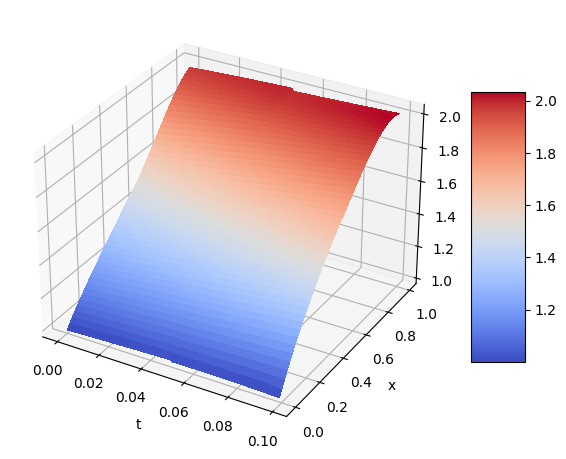

In [12]:
sol.plot2d(func_num=0)

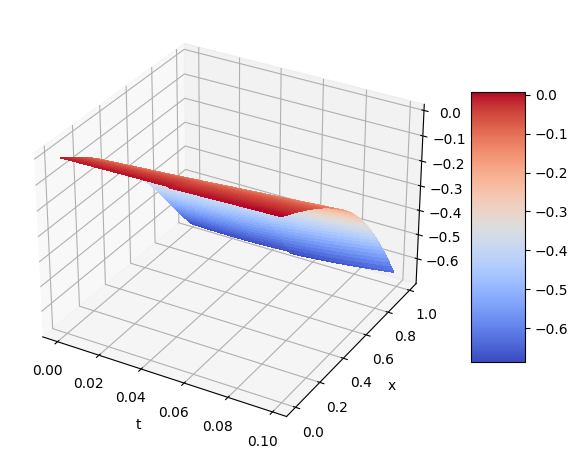

In [13]:
sol.plot2d(func_num=1)